In [36]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os
import pandas as pd
# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12



# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"


In [37]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [38]:

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [39]:
from mpl_toolkits.mplot3d import Axes3D


# Ch08. Dimensionality Reduction


## 8.4 Kernel PCA

CH05.SVM에서 sample을 고차원 공간(feature space)으로 매핑하여 SVM의 nonlinear classification과 regression을 가능하게 하는 kernel 트릭에 대해 이야기 했습니다.

High dimentional feature space에서의 linear decision boundary가 Original space에서는 nonlinear decision boundary에 해당한다는 것을 배웠습니다.

같은 기법을 PCA에 적용해 복잡한 nonlinear projection으로의 dimension reduction을 가능하게 할 수 있습니다.

이를 Kernel PCA(kPCA)라고 합니다. 

In [40]:
# make_swiss_roll은 1.5바퀴 롤이 말려있는 형태입니다.

from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)


In [41]:
X.shape

(1000, 3)

In [42]:
t.shape

(1000,)

In [43]:
t.max()

14.134506074563456

In [44]:
t.min()

4.756044768712248

In [45]:
df = pd.DataFrame(X)
df.min()

0    -9.919520
1    -0.144537
2   -11.416802
dtype: float64

In [46]:
df = pd.DataFrame(X)
df.max()

0    12.928036
1    21.176402
2    14.360618
dtype: float64

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
0    1000 non-null float64
1    1000 non-null float64
2    1000 non-null float64
dtypes: float64(3)
memory usage: 23.5 KB


### make_swiss_roll은 1.5바퀴 롤이 말려있는 형태

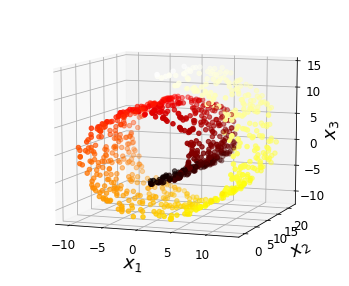

In [48]:

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

In [49]:
from sklearn.decomposition import KernelPCA 
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04) 
X_reduced = rbf_pca.fit_transform(X)

linear kernel, RBF kernel, sigmoid kernel을 사용하여 2차원으로 축소시킨 swiss roll의 모습

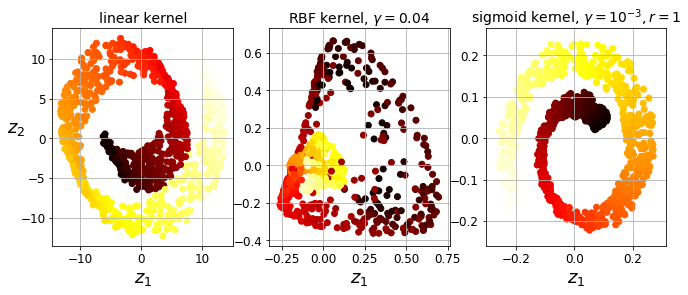

In [50]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# 8.4.1 Selecting a Kernel and Tuning Hyperparameters

kPCA는 unsupervised learning이기 때문에 좋은 kernel과 hyperparameter를 선택하기 위한 명확한 성능 측정 기준이 없습니다.


하지만 GridSearch를 통해 kPCA의 가장 좋은 kernel과 gamma parameter를 찾습니다.

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver='liblinear'))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                 

가장 좋은 kernel과 hyper parameter는 best_params_ 변수에 저장됩니다.

In [52]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


다른 방법으로는 entirely unsupervise 방법으로, lowest reconstruction error를 만드는 kernel과 hyperparameter를 선택하는 방식도 있습니다.


![1111](https://user-images.githubusercontent.com/39263586/64563051-5580de80-d389-11e9-9681-fb973130a723.PNG)



왼쪽 위가 원본 3D 데이터셋



오른쪽 위가 RBF kernel의 kPCA를 적용한 2D 데이터셋


커널 트릭 덕분에 train set을 feature map(φ)를 사용한 무한 차원의 feature space에 매핑한 다음, 변환된 데이터셋을 linear PCA를 사용해 2D projection한 것과 수학적으로 동일합니다. 




Reduced space에 있는 샘플에 대해 linear PCA를 반전시키면 재구성된 데이터 포인트는 Original space가 아닌 feature space에 놓이게 됩니다. 




이 feature space는 무한 차원이기 때문에 재구성된 포인트를 계산할 수 없고 재구성에 따른 실제 에러를 계산할 수 없습니다.


다행히 재구성된 포인트에 가깝게 매핑된 original space의 포인트를 찾을 수 있습니다. 


이를 pre-image라고 부릅니다.

pre-image를 얻게 되면 original sample과의 제곱거리를 측정할 수 있습니다.


In [53]:

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

reconstruction pre-image error를 계산 할 수 있습니다.

In [54]:

from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766125

이렇게 되면 reconstruction pre-image error을 최소화하는 kernel과 hyperparameter찾기 위해 교차검증으로 grid search를 사용할 수 있습니다.


# 8.5 LLE

Locally Linear Embedding은 또 다른 강력한 nonlinear dimensionality reduction(NLDR)입니다. 



이전 알고리즘 처럼 projection에 의존하지 않는 매니폴드 학습니다.


LLE는 각 train sample이 가장 가까운 이웃(closest neighbor)(c.n.)에 얼마나 linearly으로 연관되어 있는지 측정합니다.



그런 다음, local relationship이 가장 잘 보존되는 training set의 저차원 표현을 찾습니다.



looking for a low-dimensional representation of the training set where these local relationships are best preserved (more details shortly). 



In [55]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [56]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

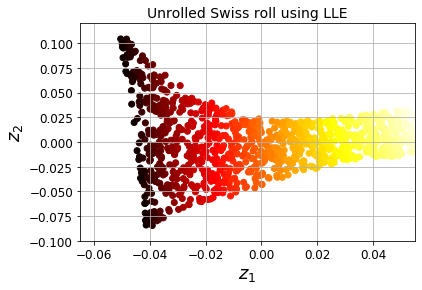

In [57]:
plt.title("Unrolled Swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()


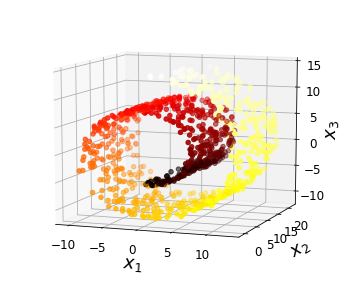

In [58]:

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

## LLE 작동 방식


training sample인 ${ x }^{ (i) }$에 대해 가장 가까운 k개의 sample을 찾습니다. (앞의 코드에서는 k = 10) 


그런 다음 neighbor에 대한 linear function로 ${ x }^{ (i) }$를 reconstruction 합니다.






${ x }^{ (i) }$와 $\sum _{j=1}^{ m }{ { w }_{ i,j }{ x }^{ (j) } } $ 사이의 제곱 거리가 최소가 되는 ${ w }_{ i,j }$를 찾는 것입니다.





${ x }^{ (j) }$가 ${ x }^{ (i) }$의 가장 가까운 k개의 neighbor 중 하나가 아닐경우에는 ${ w }_{ i,j } = 0$이 됩니다. 











Equation 8-4. LLE step 1: linearly modeling local relationships





$\hat { W } \quad =\begin{matrix} argmin \\ w \end{matrix}\sum _{ i=1 }^{ m }{ { \left( { X }^{ (i) }-\sum _{ j =1 }^{ m }{ { w }_{ i,j }{ X }^{ (j) } }  \right)  }^{ 2 } } $

W는 가중치 ${ w }_{ i,j }$를 모두 담고 있는 가중치 행렬 입니다.

조건 

* ${ w }_{ i,j }=0$  if ${ X }^{ (j) }$ is not one of the k c.n. of ${ X }^{ (i) }$

* $\sum _{ j=1 }^{ m }{ { w }_{ i,j } } =1$ i=1,2,3,...,m

가중치 행렬 $\hat { W }$은(가중치 $\widehat { w }_{i,j}$를 담고 있는) training sample 사이에 있는 local linear relationship을 담고 있습니다.



두번째 단계로는 가능한 한 이 관계가 보존되도록 training sample을 d차원 공간(d<n)으로 매핑합니다.




${Z}^{(i)}$가 d차원 공간에서 ${X}^{(i)}$의 image이라면 가능한 한 ${Z}^{(i)}$와 $\sum _{ j=1 }^{ m }{ \hat{ W}_{ i,j }{Z}^{(j)} }$ 사이의 거리가 최소화되어야 합니다.

$ \hat{ Z } \quad =\begin{matrix} argmin \\ z \end{matrix}\sum _{ i=1 }^{ m }{ { \left( { Z }^{ (i) }-\sum _{ j =1 }^{ m }{\hat { w }_{ i,j }{ Z }^{ (j) } }  \right)  }^{ 2 } } $

Equation 8-5. LLE step 2: reducing dimensionality while preserving relationships


# 8.6 Other Dimensionality Reduction Techniques

* Multidimensional Scaling (MDS)은 샘플 간의 거리를 보존하면서 차원을 축소합니다.


* Isomap은 각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프를 만듭니다.


* t-Distributed Stochastic Neighbor Embedding (t-SNE)은 비슷한 샘플을 가까이, 비슷하지 않은 샘플은 멀리 떨어지도록 차원을 축소합니다.


* Linear Discriminant Analysis (LDA)은 훈련과정에서 클래스 사이를 가장 잘 구분하는 축을 학습합니다. 이 축은 데이터가 투영되는 초평면을 정의하는데 사용할 수 있습니다.
이 알고리즘의 장점은 projection을 통해 가능한 한 클래스를 멀리 떨어지게 유지하므로 SVM과 같은 다른 classification 알고리즘을 적용하기 전에 차원을 축소시키는데 좋습니다

In [62]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [63]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [64]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [91]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_mnist = X # mnist["data"]
y_mnist = y # mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

In [92]:
X_reduced_lda.shape

(1000, 1)

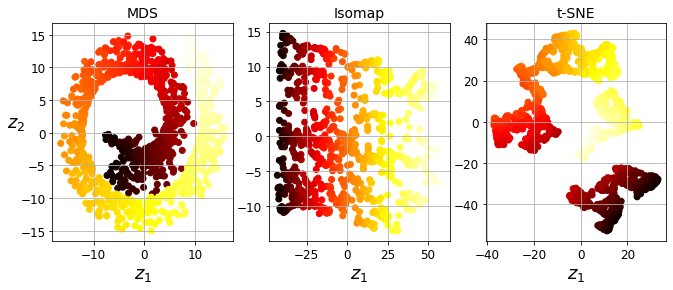

In [93]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

    
plt.show()

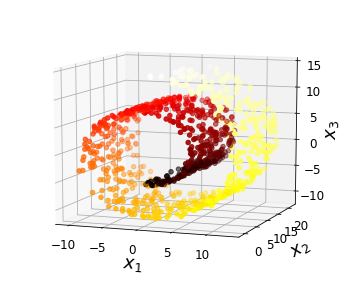

In [69]:

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()